# 検出

任意の物体が存在する領域を識別する
<img src="./images/detection.png" width="20%" style="position:relative;left:-40%;">

### ①画像にバウンディングボックスを描画してみる。
＊　バウンディングボックス：図形をちょうど囲うのに必要な大きさの，四角い箱 （矩形）のこと

In [1]:
import numpy as np
import os
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt 
from random import shuffle
from PIL import Image
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D, ReLU, Softmax 
from keras import optimizers

Using TensorFlow backend.


In [2]:
def getBB(file):
    """バウンディングボックス(BB：領域を囲む四角形)の座標を取得する
    引数：
    　file：ファイル名
    返り値：
    処理概要：
    """
    # xmlのファイル取得
    path = f'data/pet/annotations/xmls/{file}'
    
    # パースする
    tree = ET.parse(path)
    
    # 四隅の座標を取得する
    root = tree.getroot()
    ob = root.find('object')
    bndbox = ob.find('bndbox')
    xmin = bndbox.find('xmin').text
    xmax = bndbox.find('xmax').text
    ymin = bndbox.find('ymin').text
    ymax = bndbox.find('ymax').text
    four_corners = ((int(xmin), int(ymin)), (int(xmax), int(ymax)))
    return four_corners

def drawBB(file):
    """画像にバウンディングボックスを描画する
    引数：
    　file：
    返り値：
    処理概要：
    　getBBで四隅の座標を取得して、選択した画像に描画し出力する
    """
    # 画像を取得
    img_path = f'data/pet/images/{file[:-4]}.jpg'
    
    # 画像をオブジェクト化する
    img = cv2.imread(img_path)
    
    # 四隅の座標を取得する
    (xmin, ymin), (xmax, ymax) = getBB(file)
    
    # 四隅の座標から正方形を描画する
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0), 2)
    
    # 画像出力
    plt.imshow(img)

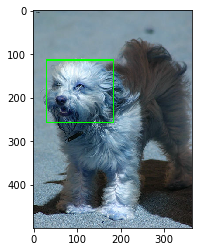

In [3]:
file = np.random.choice(os.listdir('data/pet/annotations/xmls/'))
drawBB(file)

### ②学習用データ生成のジェネレータを作成する

ニューラルネットでのバッチ処理の際に再利用するため、ジェネレータ関数として定義する。

In [4]:
def image_generator(all_files, batch_size = 32, optional_size_xy = (256, 256)):
    """画像を任意の枚数と任意の大きさで出力する
    引数：
    　all_files：全ファイル名のリスト
    　batch_size：バッチサイズ（取得したい画像の任意の枚数）
    　optional_size：リサイズしたい画像の大きさ
    返り値：
    　ジェネレーター
    処理概要：
    　画像とバウンディングボックスの座標をジェネレータで生成する。
    """
    while True:
        # 任意のバッチサイズ分の画像を樹徳
        files = np.random.choice(all_files, size = batch_size)   
        
        # 学習データ
        batch_x = [] # 画像データ
        batch_y = [] # バウンディングボックスの座標
        
        for file in files:
            # 画像パス生成＆画像オブジェクト生成
            img_path = f'data/pet/images/{file[:-4]}.jpg'
            img = Image.open(img_path)
            
            # 元の画像サイズを取得しておく
            w,h = img.size
            
            # 任意のサイズにリサイズ
            img = img.resize(optional_size_xy)
            
            # バウンディングボックスの四隅の座標を取得する
            (xmin, ymin), (xmax, ymax) = getBB(file)
            box = np.array([xmin/w, ymin/h, xmax/w, ymax/h])# ニューラルネットは入力ベクトルを0~1までに抑えなければならない(元々取得していた画像サイズで割る)
            
            # 画像データのnumpy配列化
            img = np.array(img).astype('float32')/255# ニューラルネットは入力ベクトルを0~1までに抑えなければならない(RGBの最高値で割る)
            
            # 追加
            batch_x.append(img)
            batch_y.append(box)
        
        # numpy配列に変換
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        
        # ジェネレータ化
        yield (batch_x, batch_y)

In [5]:
# ファイル一覧取得
all_files = os.listdir('data/pet/annotations/xmls/')

# ランダムに並べ替える（元々は名前順に並んでいるから）
shuffle(all_files)

# 訓練データとテストデータの分割数を指定する
split = int(0.95 * len(all_files))

# 訓練データとテストデータを分割する
train_files = all_files[0:split]
test_files  = all_files[split:]

# 画像生成ジェネレータを作成
batch_size = 32
optional_size = 256
train_generator = image_generator(train_files, batch_size = batch_size, optional_size_xy = (optional_size,optional_size))
test_generator  = image_generator(test_files, batch_size =batch_size, optional_size_xy = (optional_size,optional_size))

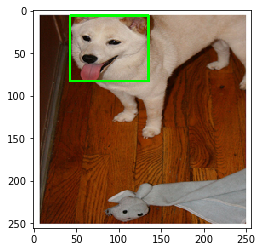

In [6]:
# 試しに出力
x, y = next(train_generator)
img = (x[0] * 255).astype('uint8') # 色を元に戻す
box = [int(optional_size *i) for i in y[0]]
cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
plt.imshow(img)

# 評価関数の作成

実際のバウンディングボックスの面積(A)と、予測されたバウンディングボックスの面積(B)のAに対する重なり具合を最小にすることを考える

In [7]:
def original_eval(boxA, boxB):
    """バウンディングボックスの面積の重なり具合を求める。
    引数：
    　boxA：バウンディングボックスA（ここでは、元のBB）
    　boxB：バウンディングボックスB（ここでは、予測したBB）
    """
    xA = np.maximum(boxA[:, 0], boxB[:, 0])
    yA = np.maximum(boxA[:, 1], boxB[:, 1])
    xB = np.minimum(boxA[:, 2], boxB[:, 2])
    yB = np.minimum(boxA[:, 3], boxB[:, 3])
    interArea = np.maximum(0, xB - xA + 1) * np.maximum(0, yB - yA + 1)
    boxAArea = (boxA[:, 2] - boxA[:, 0] + 1) * (boxA[:, 3] - boxA[:, 1] + 1)
    boxBArea = (boxB[:, 2] - boxB[:, 0] + 1) * (boxB[:, 3] - boxB[:, 1] + 1)
    unionArea = (boxAArea + boxBArea - interArea)
    return tf.reduce_mean(np.mean(interArea / unionArea))

# モデル作成

In [11]:
# 各レイヤー定義
layers = [
    Conv2D(filters=32,kernel_size=(3, 3),activation=ReLU(),input_shape=(256,256,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32,kernel_size=(3, 3),activation=ReLU()),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32,kernel_size=(3, 3),activation=ReLU()),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32,kernel_size=(3, 3),activation=ReLU()),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32,kernel_size=(3, 3),activation=ReLU()),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32,kernel_size=(3, 3),activation=ReLU()),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation=ReLU()),
    Dropout(0.2),
    Dense(128, activation=ReLU()),
    Dropout(0.2),
    Dense(4, activation=core.activations.sigmoid)
]

# 基本モデル作成
model = Sequential()

# レイヤー追加
for layer in layers:
    model.add(layer)

# モデルの学習設定
model.compile(
    loss=losses.mean_squared_error,
    optimizer=optimizers.Adam(lr=0.01),
    #metrics=[original_eval]
)

train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(
    train_generator, 
    epochs = 8,
    steps_per_epoch = train_steps,
)

Epoch 1/8
109/109 [==============================] - 13s 120ms/step - loss: 0.0256
Epoch 2/8
109/109 [==============================] - 13s 120ms/step - loss: 0.0218
Epoch 3/8
109/109 [==============================] - 13s 122ms/step - loss: 0.0218
Epoch 4/8
109/109 [==============================] - 13s 120ms/step - loss: 0.0214
Epoch 5/8
109/109 [==============================] - 13s 120ms/step - loss: 0.0215
Epoch 6/8
109/109 [==============================] - 13s 120ms/step - loss: 0.0214
Epoch 7/8
109/109 [==============================] - 13s 120ms/step - loss: 0.0215
Epoch 8/8
109/109 [==============================] - 13s 122ms/step - loss: 0.0220


# 検出

### 訓練データ

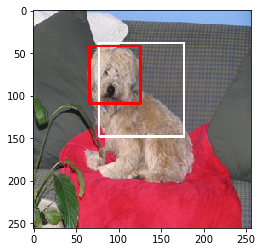

In [52]:
# データ取得
x, y = next(train_generator)
img = (x[0] * 255).astype('uint8') # 色を元に戻す

# 予測値の算出と成形
box_ = model.predict(np.array([img]))[0]
box_ = [int(optional_size*i) for i in box_]

# 正解ラベルの算出と成形
box = [int(optional_size *i) for i in y[0]]

# 予測と正解の描画
cv2.rectangle(img, (box_[0], box_[1]), (box_[2], box_[3]), (255,255,255), 2)
cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255,0,0), 2)
plt.imshow(img)

### テストデータ

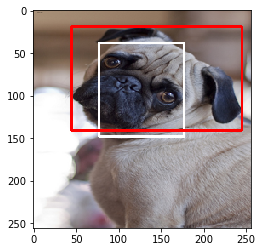

In [60]:
# データ取得
x, y = next(test_generator)
img = (x[0] * 255).astype('uint8') # 色を元に戻す

# 予測値の算出と成形
box_ = model.predict(np.array([img]))[0]
box_ = [int(optional_size*i) for i in box_]

# 正解ラベルの算出と成形
box = [int(optional_size *i) for i in y[0]]

# 予測と正解の描画
cv2.rectangle(img, (box_[0], box_[1]), (box_[2], box_[3]), (255,255,255), 2)
cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255,0,0), 2)
plt.imshow(img)